### PCA with SVM Calssifier

In [1]:
from Tumor_Classifier_Utils import *

In [3]:
data_train = scio.loadmat('Data/tumor_train_data_32.mat')
data_val = scio.loadmat('Data/tumor_val_data_32.mat')
data_test = scio.loadmat('Data/tumor_test_data_32.mat')

N = 32 # image size (64x64 after preprocessing)
num_classes = 4; # how many different types of classifications we have 

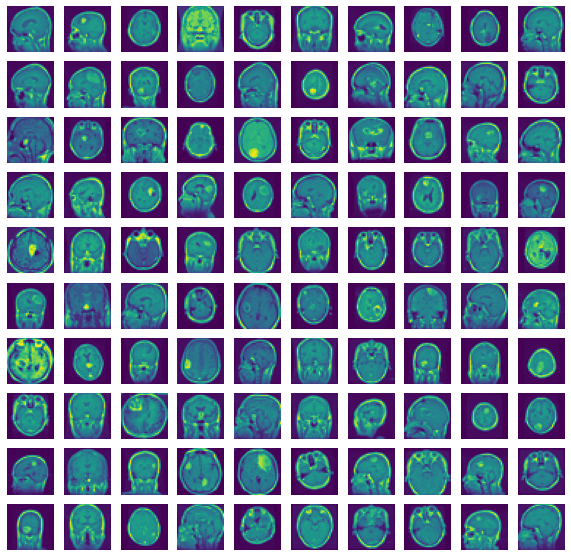

In [4]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(data_train['img_train'][:,:,i])
    ax.axis('off')

In [5]:
train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
train_y = data_train['labels_train']
val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
val_y = data_val['labels_val']
test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
test_y = data_test['labels_test']

print(train.shape)
print(val.shape)
print(test.shape)

(2500, 32, 32, 1)
(500, 32, 32, 1)
(264, 32, 32, 1)


## Formatting data for PCA

In [6]:
train_PCA = np.reshape(train[:,:,:,:], (2500, -1))
val_PCA = np.reshape(val[:,:,:,:], (500, -1))
test_PCA = np.reshape(test[:,:,:,:], (264, -1))

print(train_PCA.shape)
print(val_PCA.shape)
print(test_PCA.shape)

(2500, 1024)
(500, 1024)
(264, 1024)


## PCA

In [7]:
pca = decomposition.PCA()
pca.fit(train_PCA)

PCA()

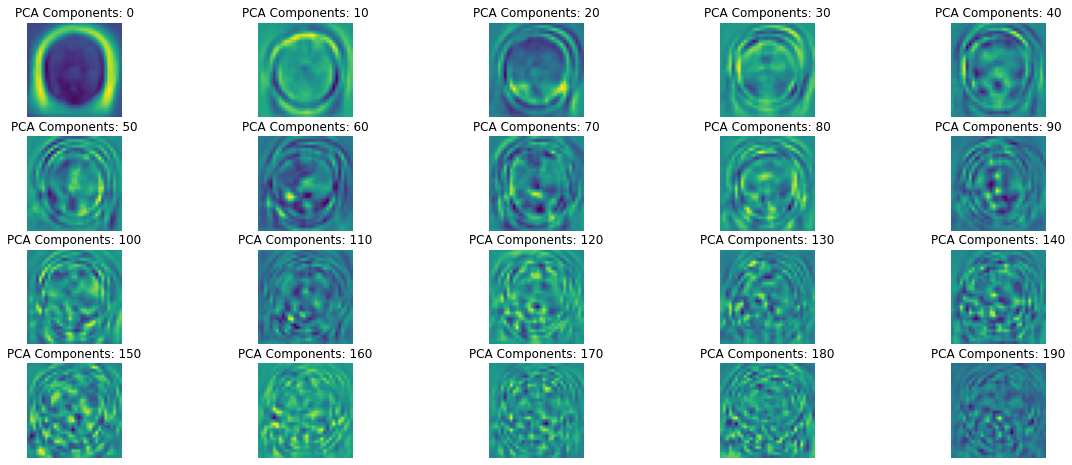

In [8]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1)
    pc = np.reshape(pca.components_[i*10,:], (N, N)) 
    ax.imshow(pc)
    ax.set_title("PCA Components: " + str(i*10))
    plt.axis('off')

In [9]:
transformed_train = pca.transform(train_PCA)
transformed_val = pca.transform(val_PCA)
transformed_test = pca.transform(test_PCA)

In [10]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
top90 = np.where(cumulative_sum > 0.90)[0][0]
top95 = np.where(cumulative_sum > 0.95)[0][0]
top99 = np.where(cumulative_sum > 0.99)[0][0]


top90: 138, top95: 228, top99: 462


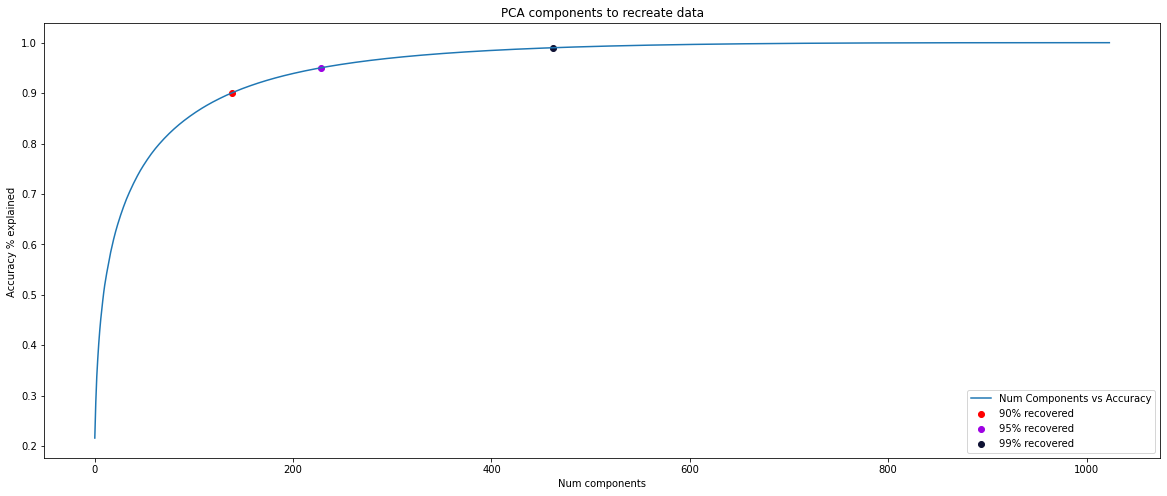

In [11]:
plot_cumulative_sum(cumulative_sum, top90, top95, top99)

(2500, 1024)
(2500, 1024)


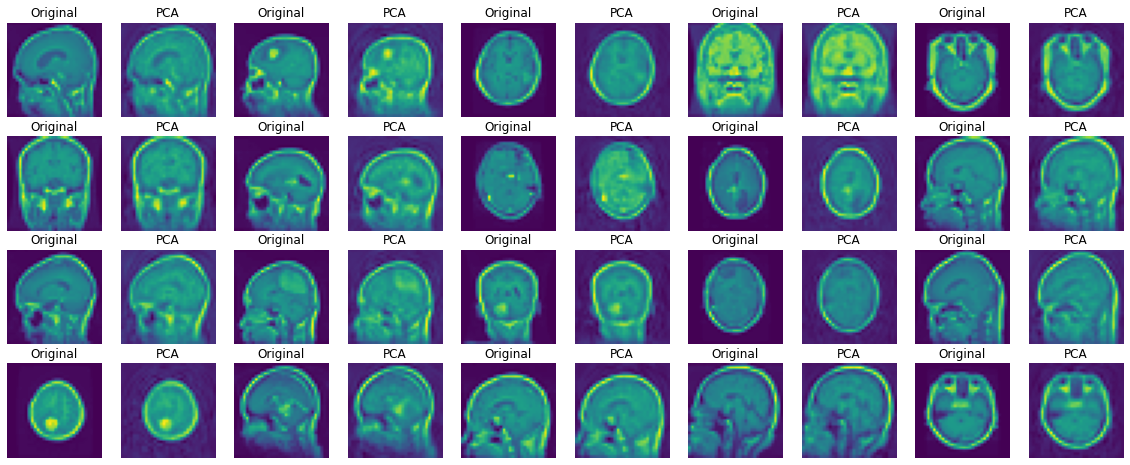

In [13]:
transformed_train_95 = transformed_train
transformed_train_95[:,top95+1:] = 0
print(transformed_train_95.shape)

transform_top95_generate = pca.inverse_transform(transformed_train_95)
print(transform_top95_generate.shape)

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, 2*i + 1)
    ax.imshow(np.reshape(train_PCA[i,:], (N,N)))
    ax.set_title('Original')
    ax.axis('off')
    ax = fig.add_subplot(4, 10, 2*i + 2)
    pc = np.reshape(transform_top95_generate[i,:], (N, N)) 
    ax.imshow(pc)
    ax.set_title('PCA')
    ax.axis('off')

In [14]:
# choose to use 95% recreation
transformed_train_95 = transformed_train[:, 0:top95]
transformed_val_95 = transformed_val[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

print(transformed_train_95.shape)
print(train_y.shape)

(2500, 228)
(2500, 1)


### SVM Classifier

In [15]:
def search_hyperparams(model, params, X_train, Y_train, X_validate, Y_validate):
    # Create list of all possible combinations
    param_list = list(ParameterGrid(params))
    
    # Initialising 
    best_result = 0.00;
    best_params = param_list[0];
    worst_result = 1.00;
    worst_params = param_list[0];
    # looping through all parameters in parameter list
    for params in param_list:
        # creating model with set parameters
        model = model.set_params(**params)
        # training the model
        model.fit(X_train, Y_train)
        # retrieving model score
        result = model.score(X_validate, Y_validate)
        # checking if model score is better, then allocating best parameters
        if result > best_result:
            best_result = result
            best_params = params
        if result < worst_result:
            worst_result = result
            worst_params = params
    
    # Return the best
    print(best_params)
    print("Validation Accuracy " + str(best_result))
    print(worst_params)
    print("Validation Accuracy " + str(worst_result))
    return best_params

In [16]:
param_grid = {'class_weight': ['balanced'], 'decision_function_shape': ['ovo', 'ovr'], 'C': list(range(1, 30)), 'gamma': [0.00005, 0.0001, 0.0003, 0.0005], 'kernel' : ['rbf', 'sigmoid']}

# Find Optimal Hyperparameters and then create model
model = SVC()
best_params = search_hyperparams(model, param_grid, transformed_train_95, train_y, transformed_val_95, val_y)


c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: D

{'C': 27, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 0.0005, 'kernel': 'rbf'}
Validation Accuracy 0.614
{'C': 11, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 5e-05, 'kernel': 'sigmoid'}
Validation Accuracy 0.334


In [17]:
rf = model.set_params(**best_params)
rf.fit(transformed_train_95, train_y)

c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=27, class_weight='balanced', decision_function_shape='ovo', gamma=0.0005)

In [18]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax, display_labels=labels)
    #conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax, display_labels=labels)
    #conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.23      0.18      0.20        50
           1       0.73      0.78      0.75        76
           2       0.79      0.68      0.73        87
           3       0.40      0.53      0.45        51

    accuracy                           0.58       264
   macro avg       0.53      0.54      0.53       264
weighted avg       0.59      0.58      0.58       264



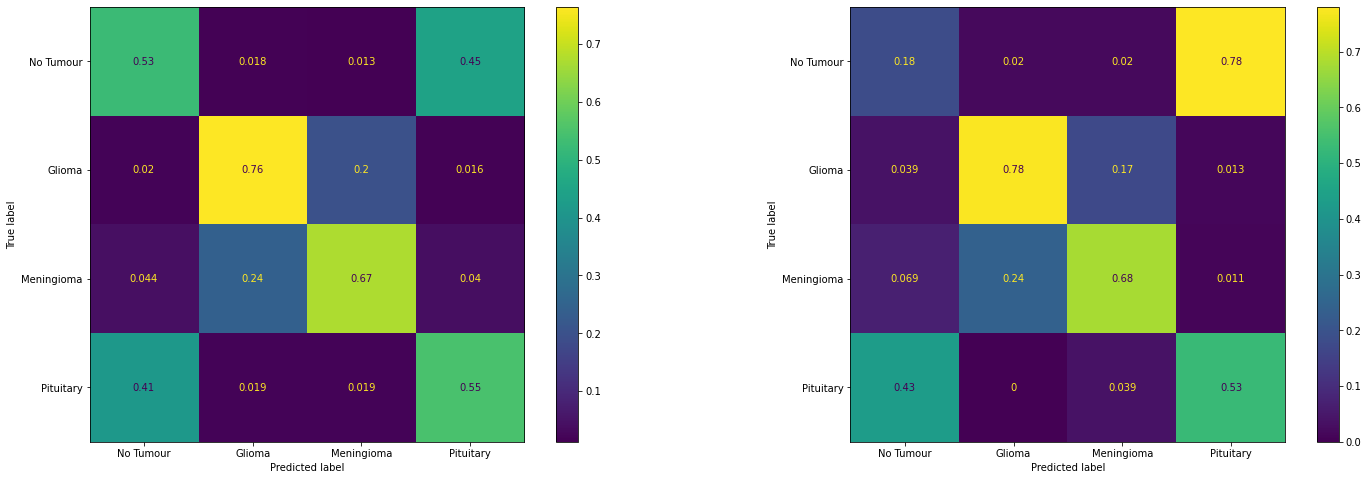

In [19]:
eval_model(rf, transformed_train_95, train_y, transformed_test_95, test_y)

## LDA

In [20]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(np.array(transformed_train_95), np.array(train_y))

transformed_train_LDA = lda.transform(transformed_train_95)
transformed_val_LDA = lda.transform(transformed_val_95)
transformed_test_LDA = lda.transform(transformed_test_95)

c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
print(np.shape(transformed_train_LDA))

(2500, 3)


In [24]:
param_grid = {'class_weight': ['balanced'], 'decision_function_shape': ['ovo', 'ovr'], 'C': list(range(1, 30)), 'gamma': [0.00005, 0.0001, 0.0003, 0.0005], 'kernel' : ['rbf', 'sigmoid']}

# Find Optimal Hyperparameters and then create model
model2 = SVC()
best_params2 = search_hyperparams(model2, param_grid, transformed_train_LDA, train_y, transformed_val_LDA, val_y)

rf2 = model2.set_params(**best_params2)
rf2.fit(transformed_train_LDA, train_y)

eval_model(rf2, transformed_train_LDA, train_y, transformed_test_LDA, test_y)

c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: D